In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import community as community_louvain
import tqdm
import torch
from torch import nn

from model.tgn import TGN
from utils.data_processing import get_data, compute_time_statistics
from utils.utils import EarlyStopMonitor, RandEdgeSampler, get_neighbor_finder
from evaluation.evaluation import eval_edge_prediction, eval_embedding, eval_prob, eval_dynamic
from sklearn import manifold
from sklearn.decomposition import PCA
from pathlib import Path

## A. Model setup

Loading the data used to train the model:

In [2]:
data_set = "politoEdge_graph_t_0.1_d_1"

### Extract data for training, validation and testing
node_features, edge_features, full_data, train_data, val_data, test_data, new_node_val_data, \
new_node_test_data = get_data(data_set) #, randomize_features=True)

# Initialize training neighbor finder to retrieve temporal graph
train_ngh_finder = get_neighbor_finder(train_data, False)

# Initialize validation and test neighbor finder to retrieve temporal graph
full_ngh_finder = get_neighbor_finder(full_data, False)

(15577, 172)
The dataset has 79261 interactions, involving 15576 different nodes
The training dataset has 33505 interactions, involving 9946 different nodes
The validation dataset has 11889 interactions, involving 4585 different nodes
The test dataset has 11885 interactions, involving 4759 different nodes
The new node validation dataset has 7767 interactions, involving 3616 different nodes
The new node test dataset has 7579 interactions, involving 3606 different nodes
1557 nodes were used for the inductive testing, i.e. are never seen during training


Choice of parameters:

In [3]:
# Compute time statistics
mean_time_shift_src, std_time_shift_src, mean_time_shift_dst, std_time_shift_dst = \
  compute_time_statistics(full_data.sources, full_data.destinations, full_data.timestamps)

NUM_LAYER = 1
NUM_HEADS = 2
DROP_OUT = 0.1
USE_MEMORY = True
MESSAGE_DIM = 100
MEMORY_DIM = 172
NUM_NEIGHBORS = 10

Loading the model:

In [4]:
model = TGN(neighbor_finder=full_ngh_finder, node_features=node_features,
            edge_features=edge_features, device='cpu',
            n_layers=NUM_LAYER,
            n_heads=NUM_HEADS, dropout=DROP_OUT, use_memory=USE_MEMORY,
            message_dimension=MESSAGE_DIM, memory_dimension=MEMORY_DIM,
            memory_update_at_start= True,
            embedding_module_type='graph_attention',
            message_function='identity',
            aggregator_type='last',
            memory_updater_type='gru',
            n_neighbors=NUM_NEIGHBORS,
            mean_time_shift_src=mean_time_shift_src, std_time_shift_src=std_time_shift_src,
            mean_time_shift_dst=mean_time_shift_dst, std_time_shift_dst=std_time_shift_dst,
            use_destination_embedding_in_message=False,
            use_source_embedding_in_message=False,
            dyrep=False)
model.load_state_dict(torch.load(f'saved_models/tgn-attn-{data_set}.pth', map_location=torch.device('cpu')))
model.eval()

TGN(
  (time_encoder): TimeEncode(
    (w): Linear(in_features=1, out_features=172, bias=True)
  )
  (memory): Memory()
  (message_aggregator): LastMessageAggregator()
  (message_function): IdentityMessageFunction()
  (memory_updater): GRUMemoryUpdater(
    (memory): Memory()
    (layer_norm): LayerNorm((172,), eps=1e-05, elementwise_affine=True)
    (memory_updater): GRUCell(816, 172)
  )
  (embedding_module): GraphAttentionEmbedding(
    (time_encoder): TimeEncode(
      (w): Linear(in_features=1, out_features=172, bias=True)
    )
    (attention_models): ModuleList(
      (0): TemporalAttentionLayer(
        (merger): MergeLayer(
          (fc1): Linear(in_features=516, out_features=172, bias=True)
          (fc2): Linear(in_features=172, out_features=172, bias=True)
          (act): ReLU()
        )
        (multi_head_target): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=344, out_features=344, bias=True)
        )
      )
    )
  )
  (affin

## B. Calculation of embeddings and their deformations

Initialization of model's memory and computation of PCA axis associated to the final embeddings, which will be used for all the following plots:

In [5]:
model.memory.__init_memory__()
model.set_neighbor_finder(full_ngh_finder)
nodes = np.unique(np.hstack((full_data.sources,full_data.destinations)))
batch_size = 200
epoch = 1e7

emb_temp, memory = eval_embedding(model,
                            full_data, NUM_NEIGHBORS, epoch, batch_size = batch_size)

method_PCA_emb = PCA(n_components=2)
method_PCA_mem = PCA(n_components=2)

method_PCA_emb.fit(emb_temp[-1][2])
method_PCA_mem.fit(memory[-1][2])

PCA(n_components=2)

Embeddings and deformations for a 1 hour time step:

Embeddings at time  0


100%|██████████| 15576/15576 [00:00<00:00, 743701.74it/s]


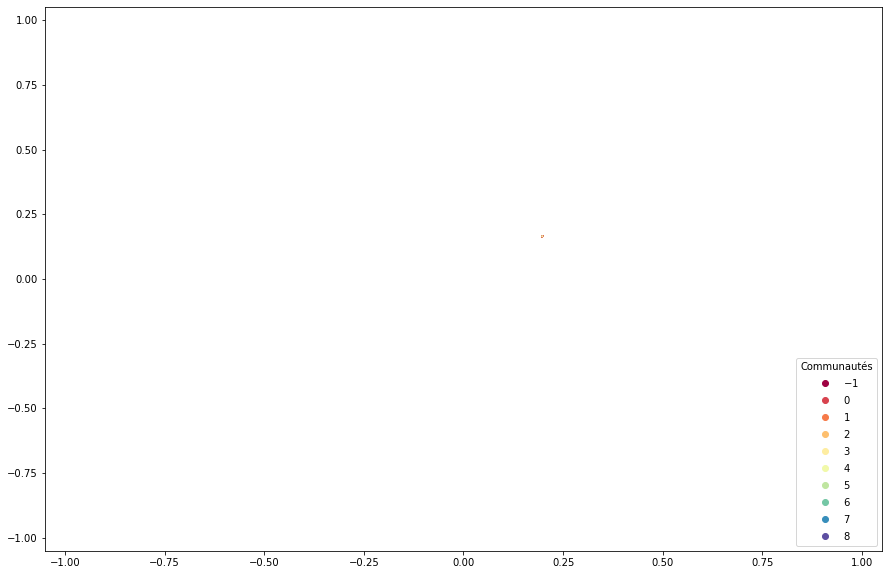

Community  0  consists of  4616  users, i.e.  0.2963533641499743 % of the total number of users.
Community  1  consists of  3569  users, i.e.  0.22913456599897278 % of the total number of users.
Community  2  consists of  2595  users, i.e.  0.1666024653312789 % of the total number of users.
Community  3  consists of  1176  users, i.e.  0.07550077041602465 % of the total number of users.
Community  4  consists of  656  users, i.e.  0.042116076014381096 % of the total number of users.
Community  5  consists of  530  users, i.e.  0.034026707755521315 % of the total number of users.
Community  6  consists of  496  users, i.e.  0.03184386235233693 % of the total number of users.
Community  7  consists of  418  users, i.e.  0.026836158192090395 % of the total number of users.
Community  8  consists of  311  users, i.e.  0.019966615305598356 % of the total number of users.
Community -1 (other users) consists of  1209  users, i.e.  0.07761941448382126 % of the total number of users.
Etape  1  

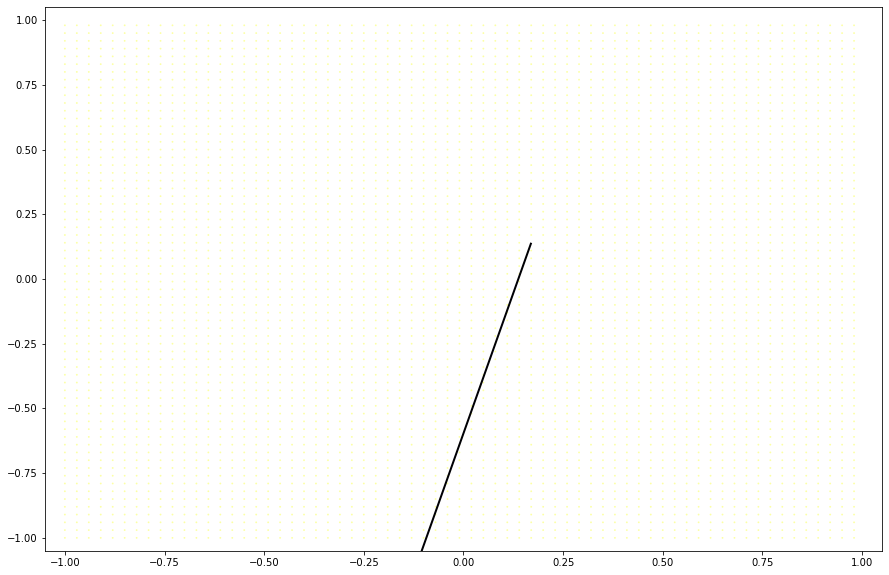

Embeddings at time  tensor(11264.)


100%|██████████| 15576/15576 [00:00<00:00, 821984.16it/s]


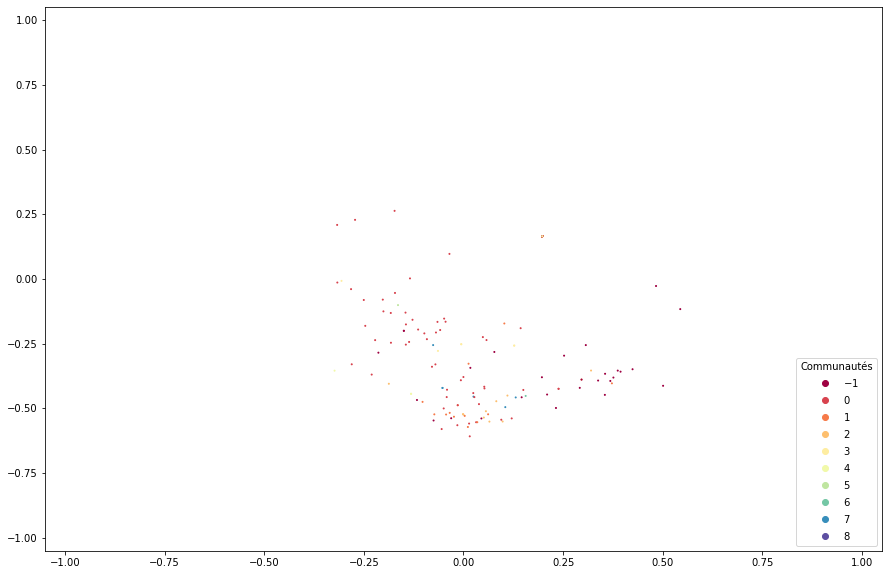

Etape  2  sur  15
Evolutions between embeddings at time  tensor(16969.)  and at time  tensor(11264.) .


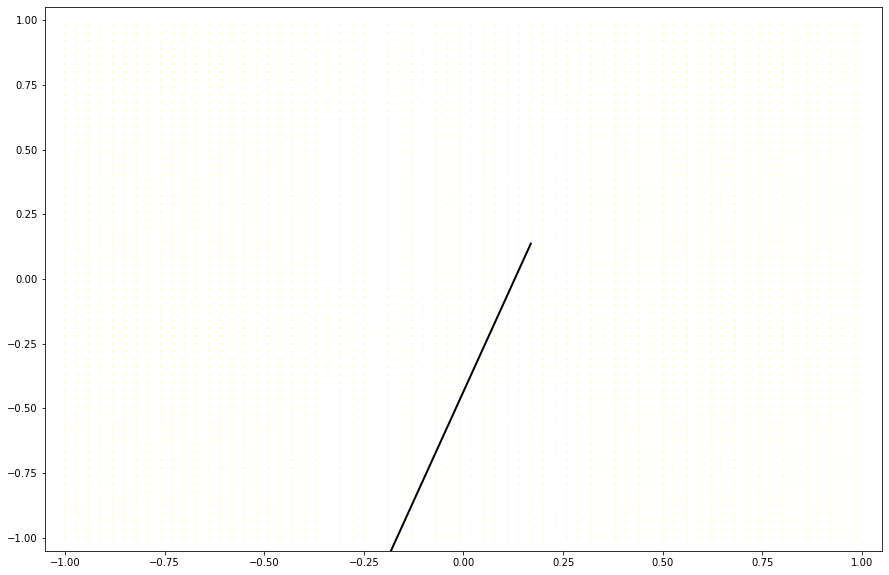

Embeddings at time  tensor(16969.)


100%|██████████| 15576/15576 [00:00<00:00, 918685.46it/s]


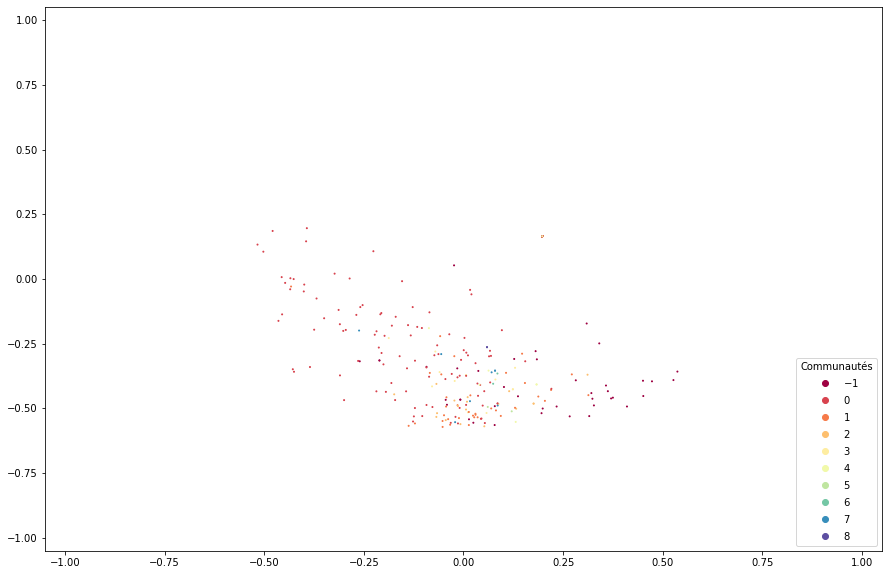

Etape  3  sur  15
Evolutions between embeddings at time  tensor(19091.)  and at time  tensor(16969.) .


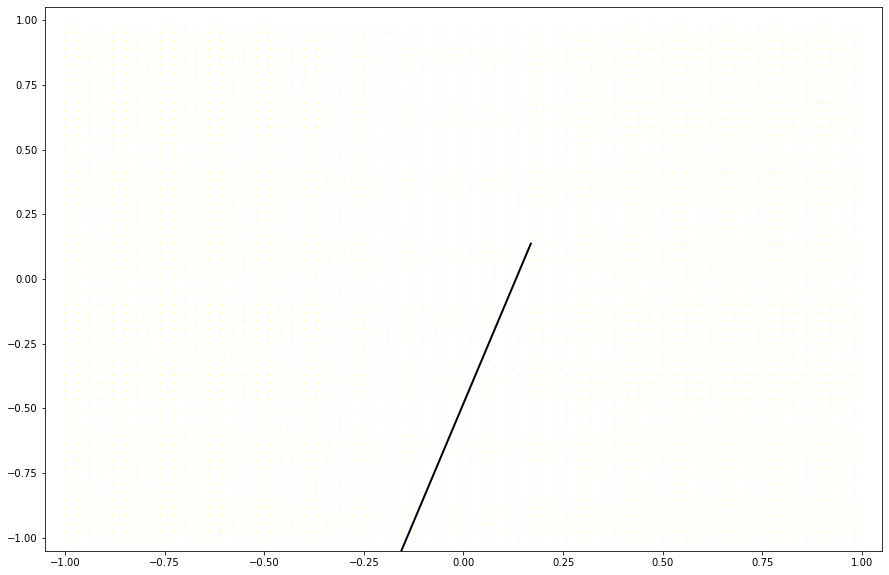

Embeddings at time  tensor(19091.)


100%|██████████| 15576/15576 [00:00<00:00, 976130.75it/s]


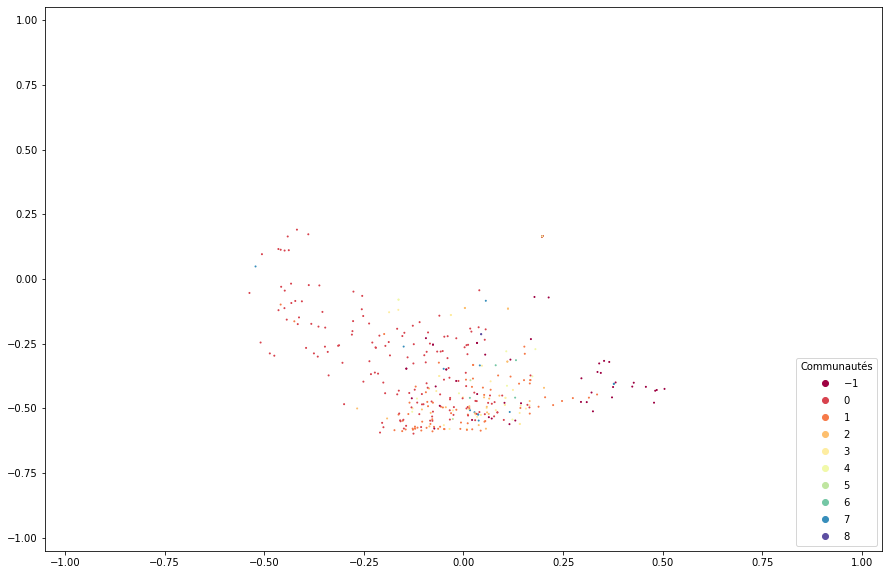

Etape  4  sur  15
Evolutions between embeddings at time  tensor(20458.)  and at time  tensor(19091.) .


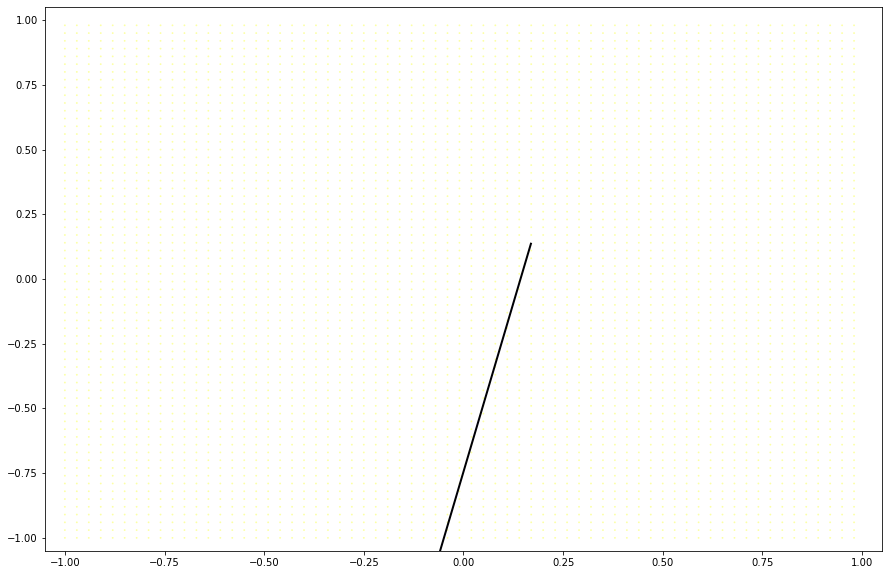

Embeddings at time  tensor(20458.)


100%|██████████| 15576/15576 [00:00<00:00, 1041056.81it/s]


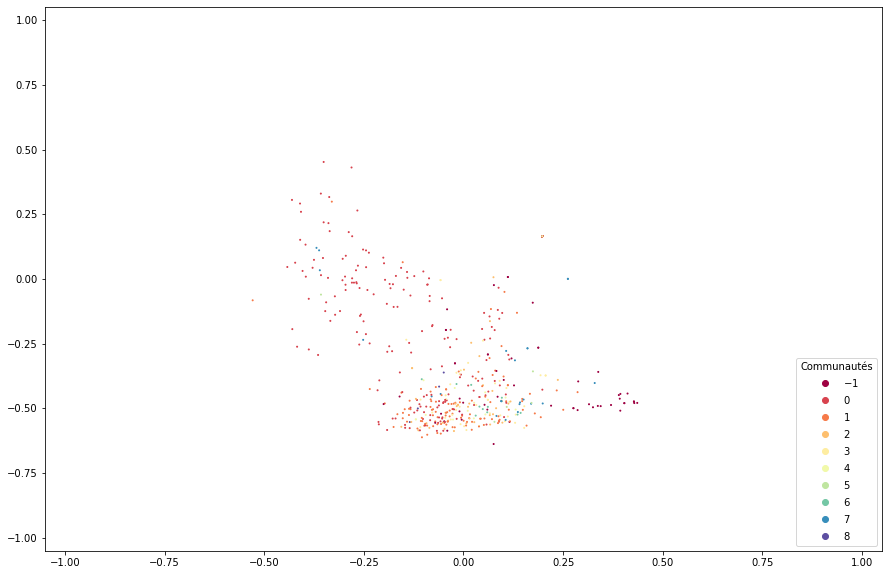

Etape  5  sur  15
Evolutions between embeddings at time  tensor(21551.)  and at time  tensor(20458.) .


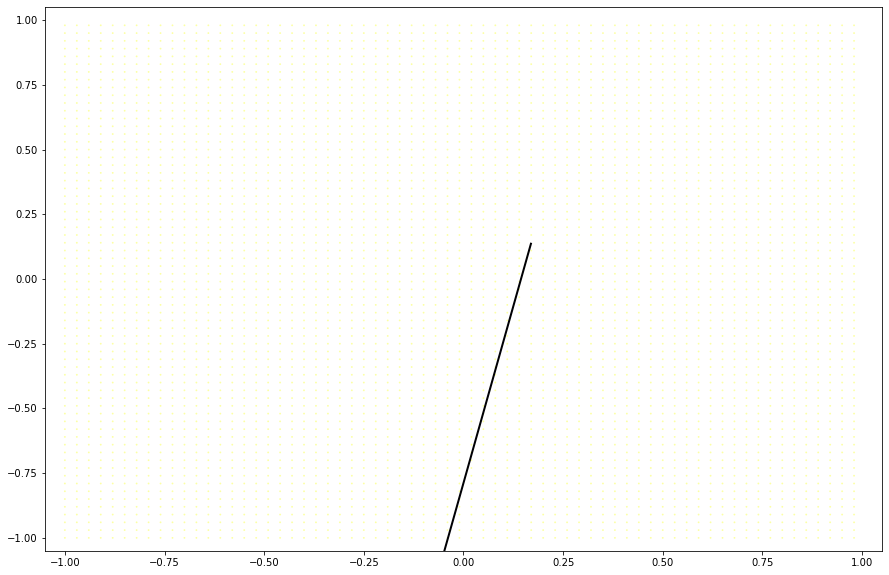

Embeddings at time  tensor(21551.)


100%|██████████| 15576/15576 [00:00<00:00, 1420104.32it/s]


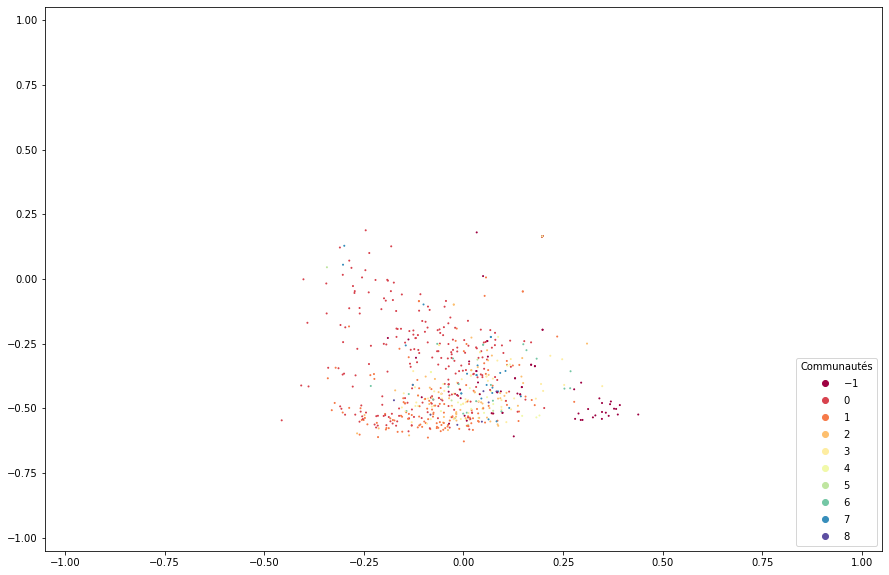

Etape  6  sur  15
Evolutions between embeddings at time  tensor(22305.)  and at time  tensor(21551.) .


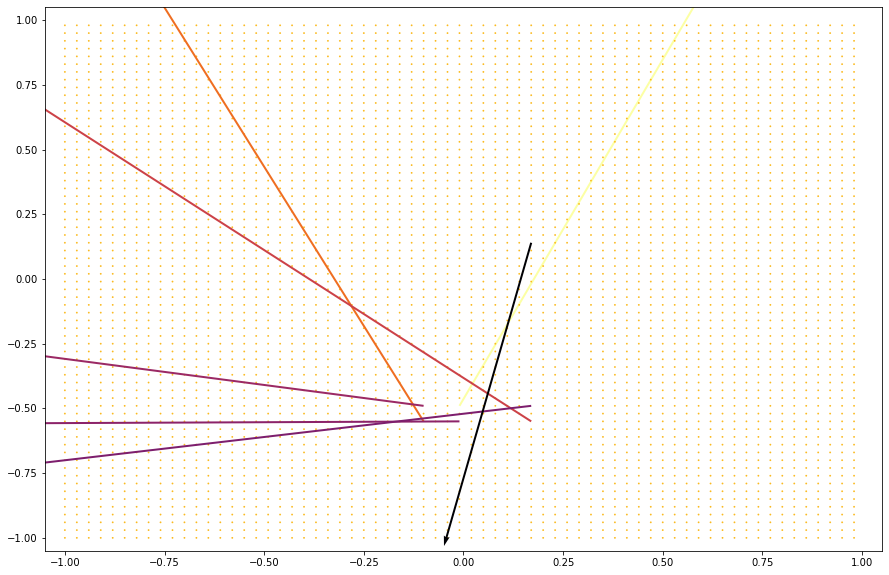

Embeddings at time  tensor(22305.)


100%|██████████| 15576/15576 [00:00<00:00, 974122.19it/s]


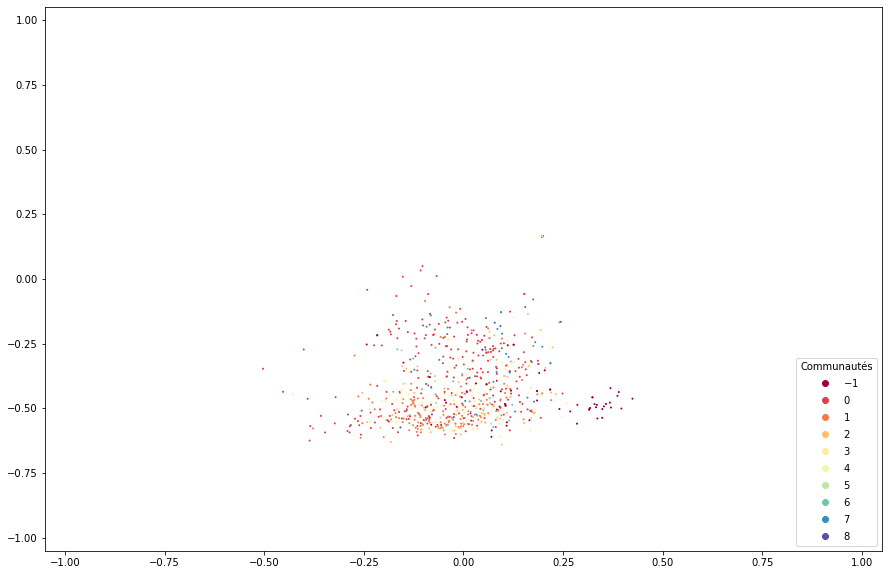

Etape  7  sur  15
Evolutions between embeddings at time  tensor(25319.)  and at time  tensor(22305.) .


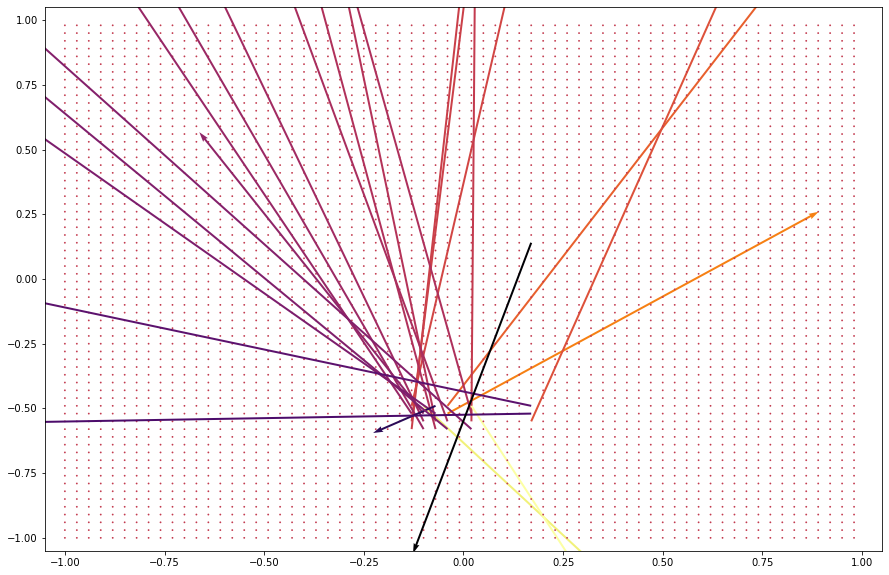

Embeddings at time  tensor(25319.)


100%|██████████| 15576/15576 [00:00<00:00, 1562145.31it/s]


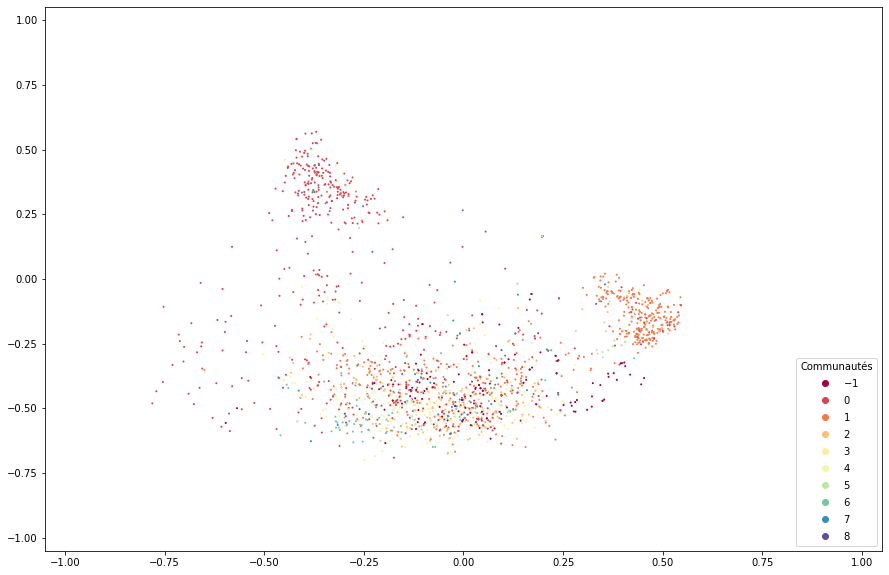

Etape  8  sur  15
Evolutions between embeddings at time  tensor(28813.)  and at time  tensor(25319.) .


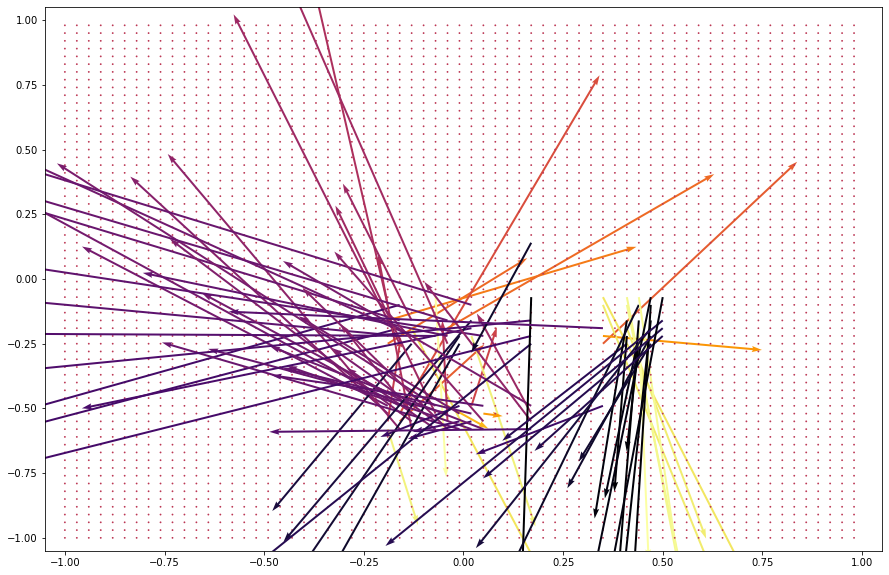

Embeddings at time  tensor(28813.)


100%|██████████| 15576/15576 [00:00<00:00, 780932.61it/s]


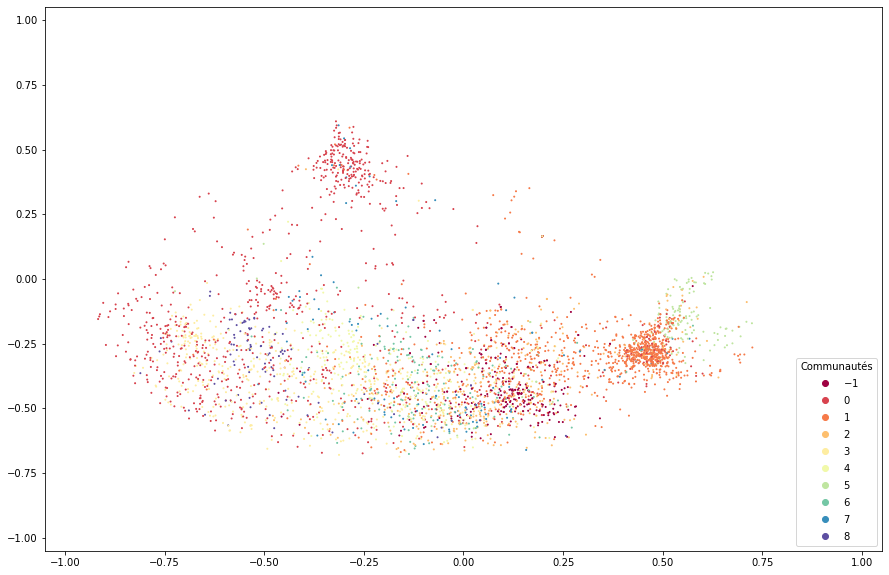

Etape  9  sur  15
Evolutions between embeddings at time  tensor(32476.)  and at time  tensor(28813.) .


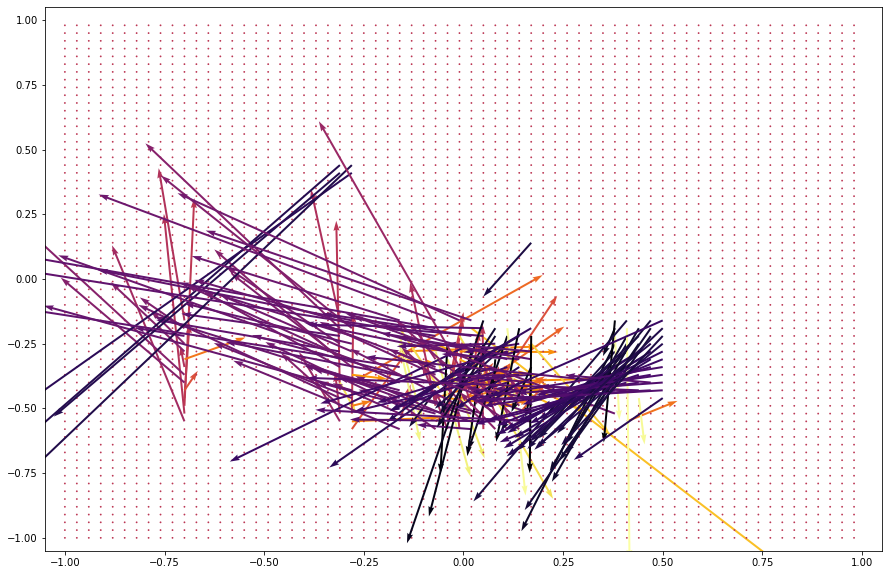

Embeddings at time  tensor(32476.)


100%|██████████| 15576/15576 [00:00<00:00, 822077.25it/s]


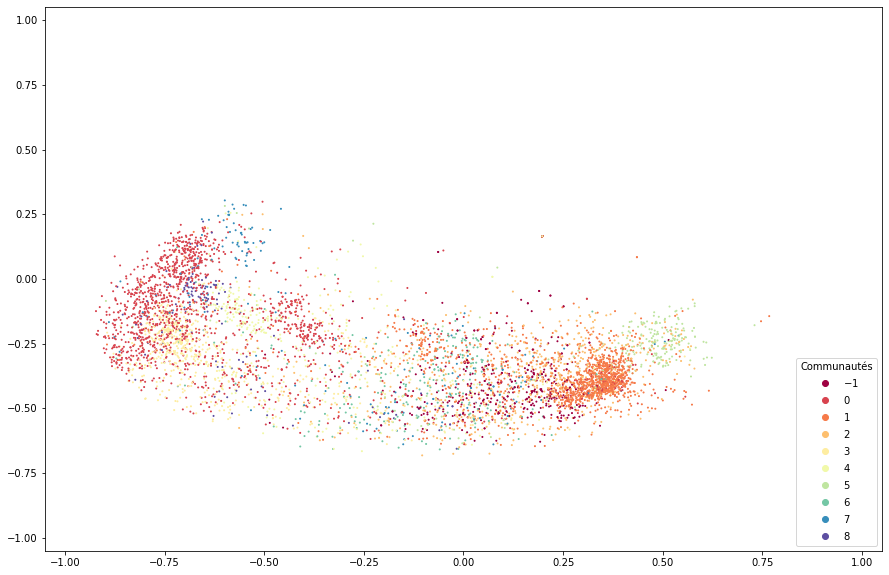

Etape  10  sur  15
Evolutions between embeddings at time  tensor(36016.)  and at time  tensor(32476.) .


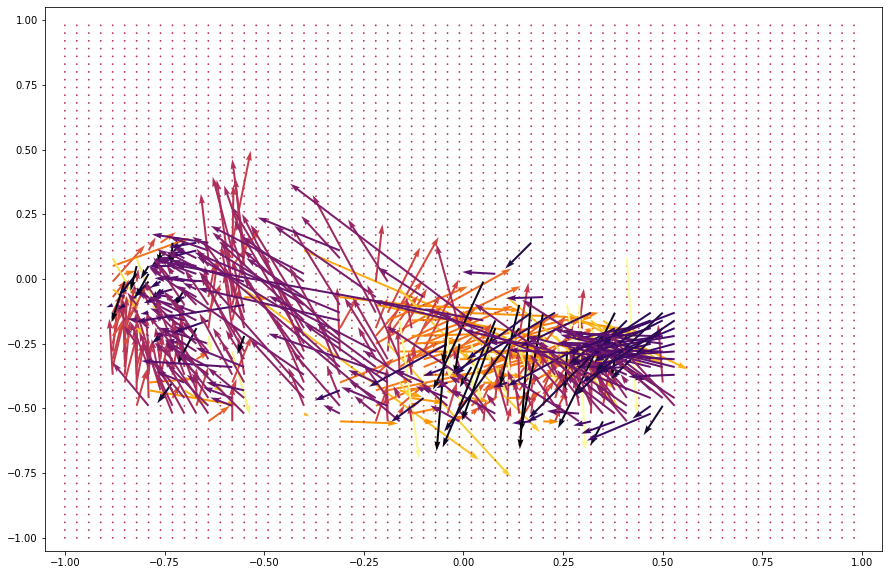

Embeddings at time  tensor(36016.)


100%|██████████| 15576/15576 [00:00<00:00, 918685.46it/s]


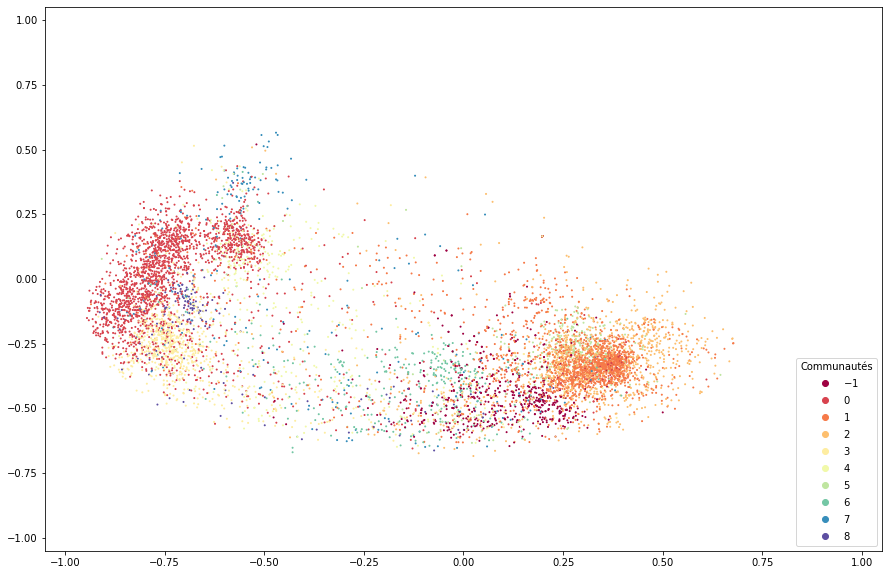

Etape  11  sur  15
Evolutions between embeddings at time  tensor(39616.)  and at time  tensor(36016.) .


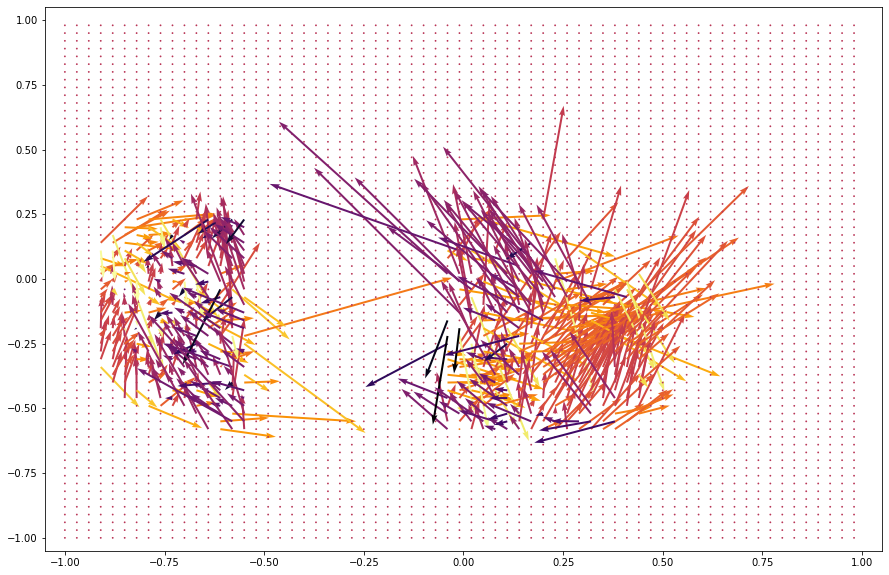

Embeddings at time  tensor(39616.)


100%|██████████| 15576/15576 [00:00<00:00, 960657.58it/s]


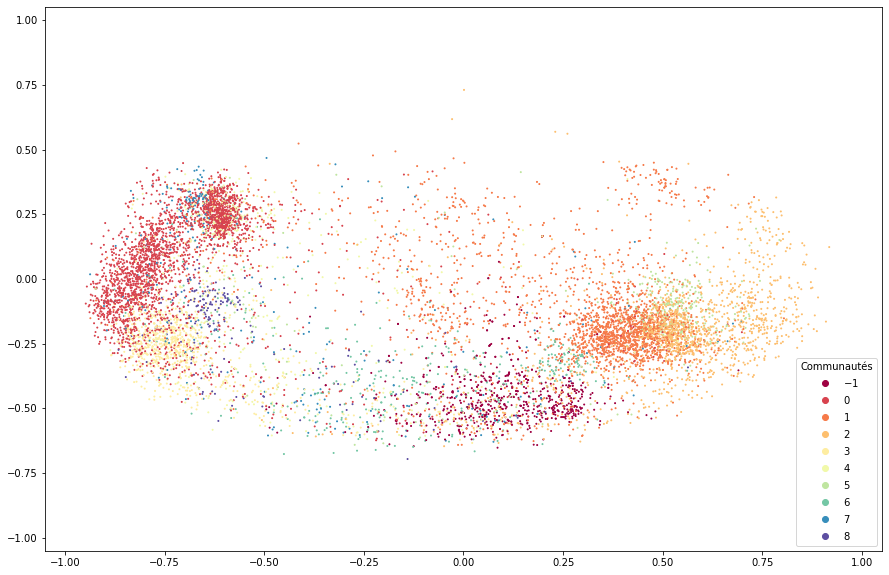

Etape  12  sur  15
Evolutions between embeddings at time  tensor(43214.)  and at time  tensor(39616.) .


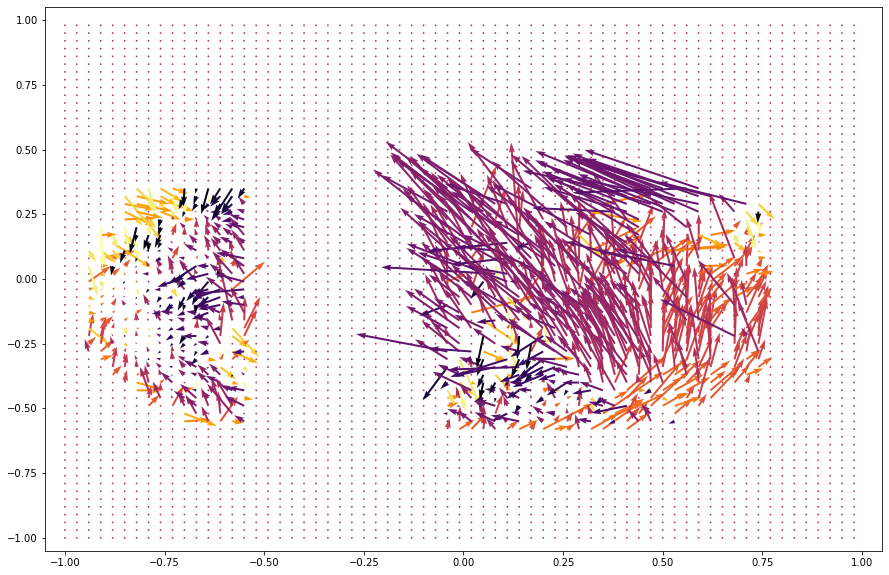

Embeddings at time  tensor(43214.)


100%|██████████| 15576/15576 [00:00<00:00, 999670.69it/s]


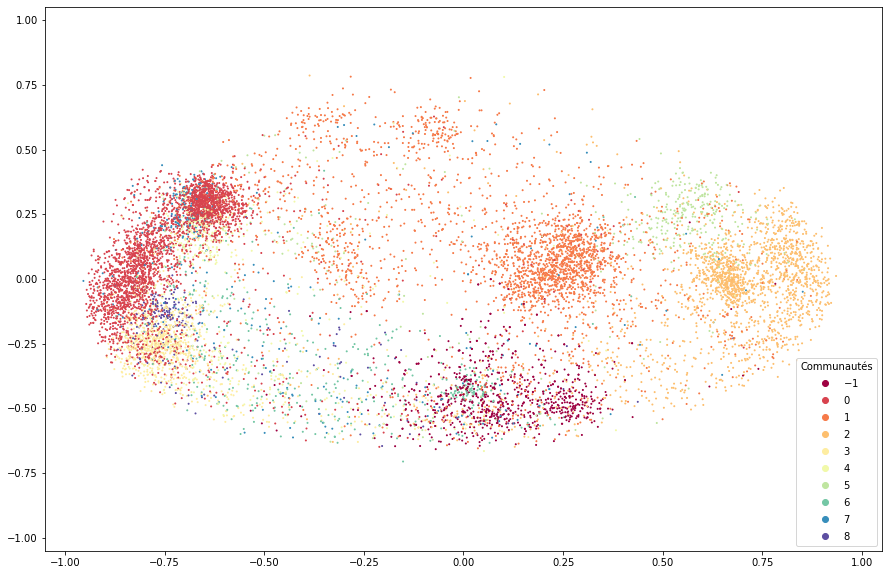

Etape  13  sur  15
Evolutions between embeddings at time  tensor(46875.)  and at time  tensor(43214.) .


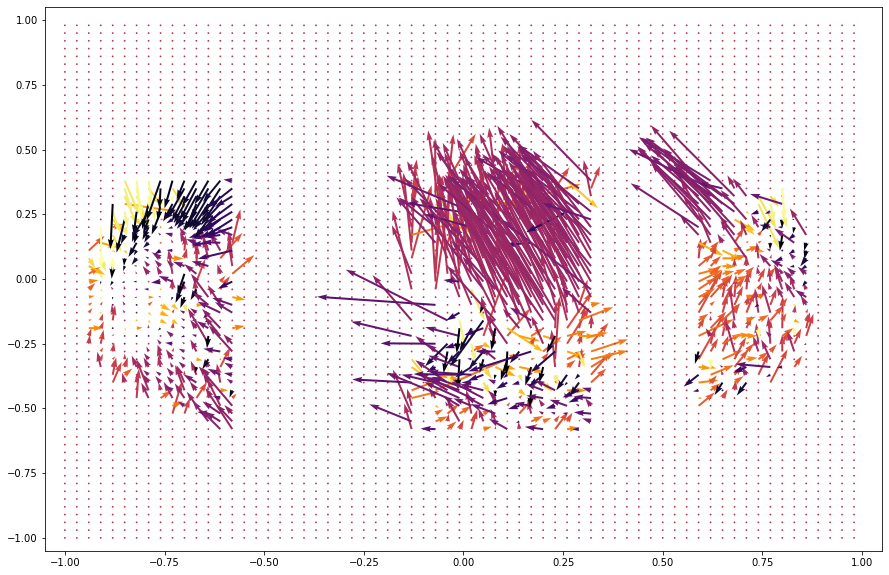

Embeddings at time  tensor(46875.)


100%|██████████| 15576/15576 [00:00<00:00, 994527.01it/s]


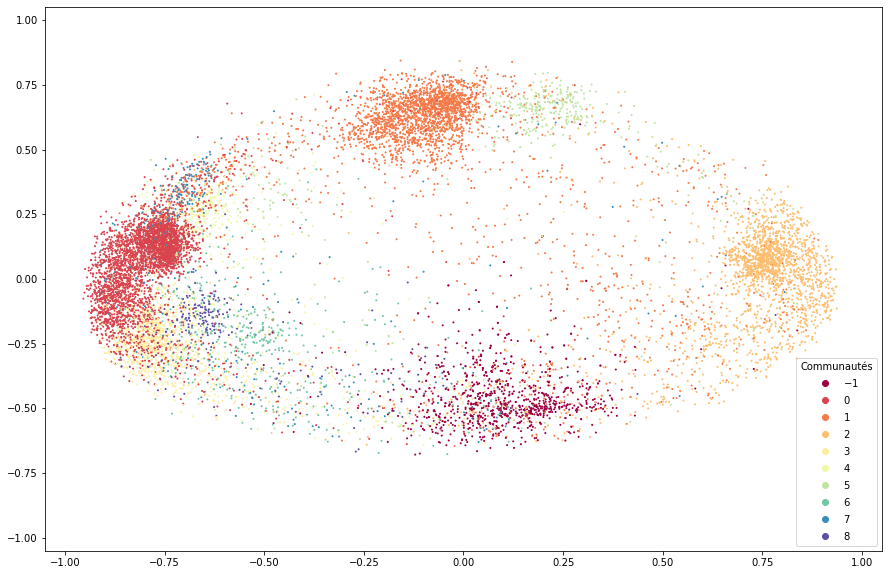

Etape  14  sur  15
Evolutions between embeddings at time  tensor(50453.)  and at time  tensor(46875.) .


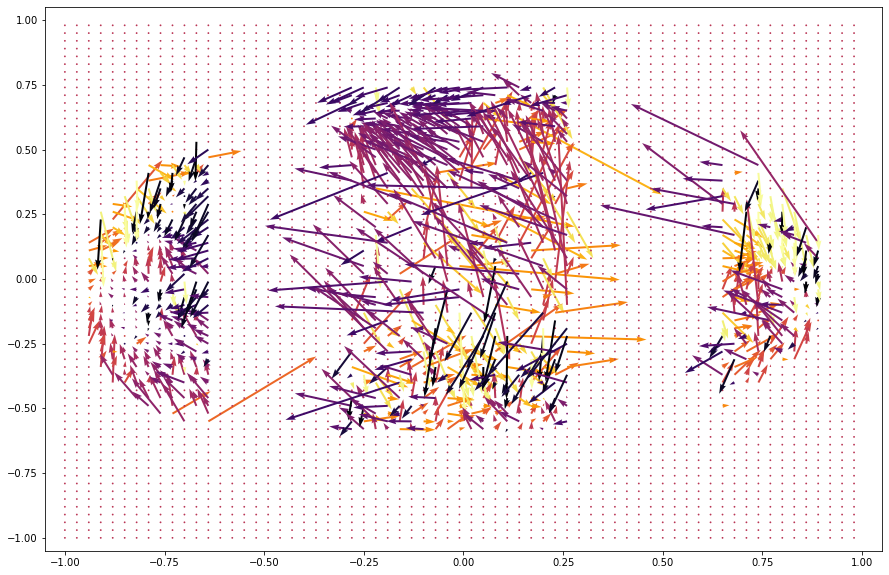

Embeddings at time  tensor(50453.)


100%|██████████| 15576/15576 [00:00<00:00, 998921.72it/s]


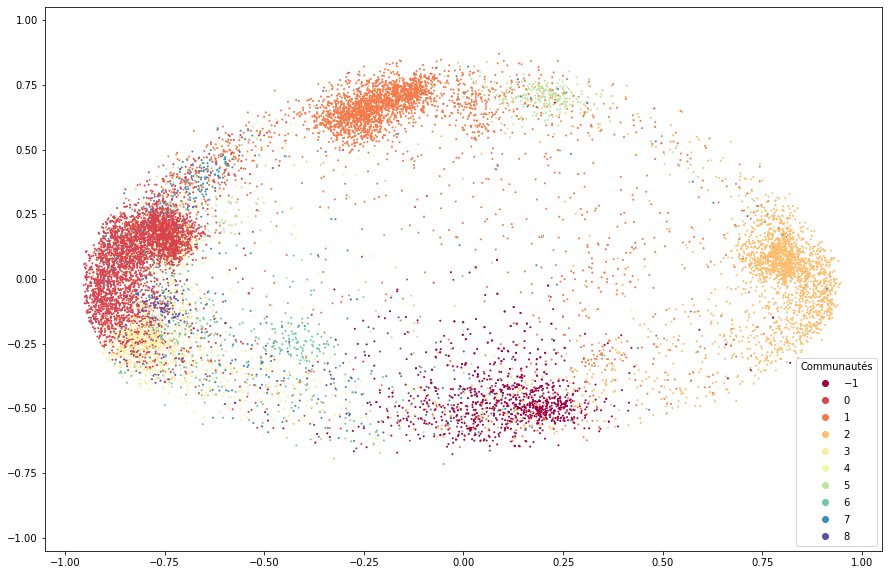

Etape  15  sur  15
Evolutions between embeddings at time  tensor(54022.)  and at time  tensor(50453.) .


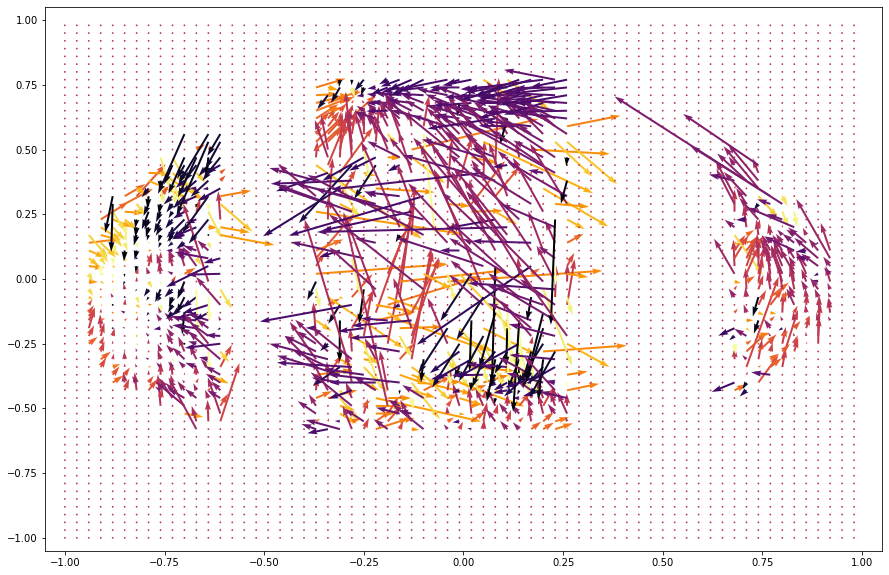

Embeddings at time  tensor(54022.)


100%|██████████| 15576/15576 [00:00<00:00, 997107.43it/s]


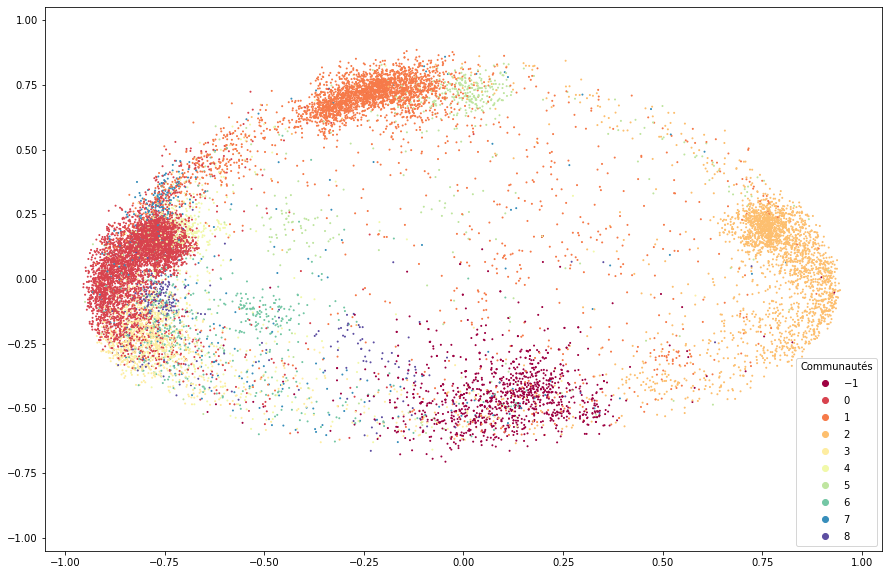

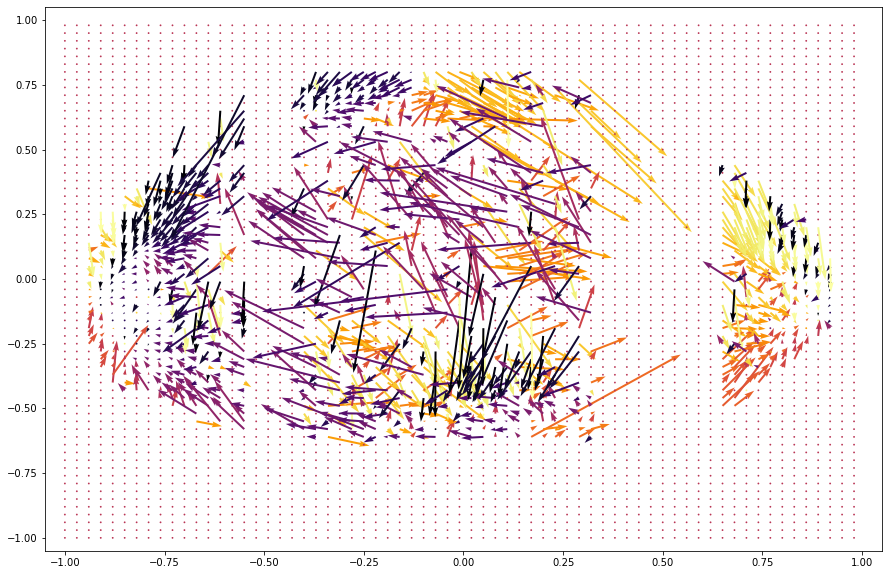

Final embeddings


100%|██████████| 15576/15576 [00:00<?, ?it/s]


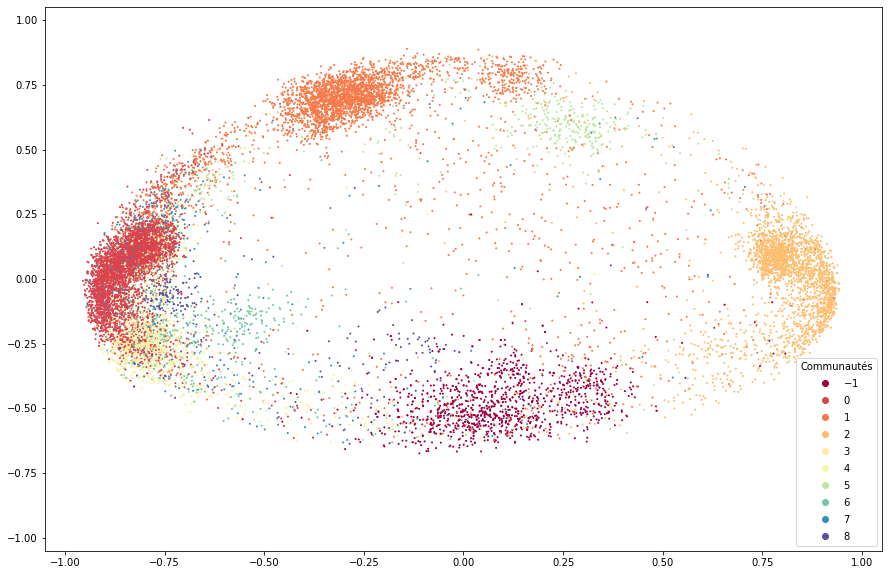

Community  0  consists of  4616  users, i.e.  0.2963533641499743 % of the total number of users.
Community  1  consists of  3569  users, i.e.  0.22913456599897278 % of the total number of users.
Community  2  consists of  2595  users, i.e.  0.1666024653312789 % of the total number of users.
Community  3  consists of  1176  users, i.e.  0.07550077041602465 % of the total number of users.
Community  4  consists of  656  users, i.e.  0.042116076014381096 % of the total number of users.
Community  5  consists of  530  users, i.e.  0.034026707755521315 % of the total number of users.
Community  6  consists of  496  users, i.e.  0.03184386235233693 % of the total number of users.
Community  7  consists of  418  users, i.e.  0.026836158192090395 % of the total number of users.
Community  8  consists of  311  users, i.e.  0.019966615305598356 % of the total number of users.
Community -1 (other users) consists of  1209  users, i.e.  0.07761941448382126 % of the total number of users.


In [6]:
model.memory.__init_memory__()
arrows_list = eval_dynamic(model, method_PCA_emb.components_, full_data, NUM_NEIGHBORS, time_step = 3600, batch_size = batch_size,
            values = [-1,1,-1,1], step_arrow = 0.03, threshold_tile = 10, clip_value = 10, plt_emb = True, nb_com = 9)

## C. Analysis of vector fields

Vectors' norms distributions:

Plot  1 / 16


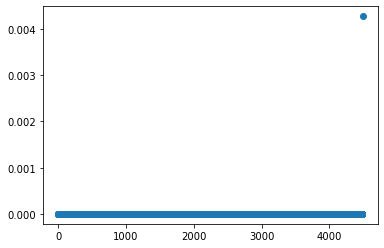

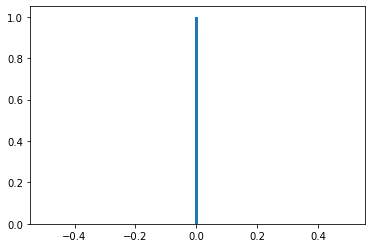

Plot  2 / 16


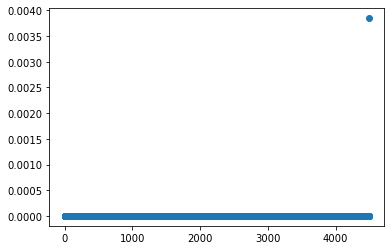

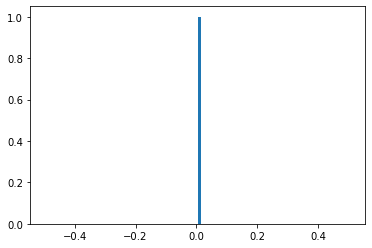

Plot  3 / 16


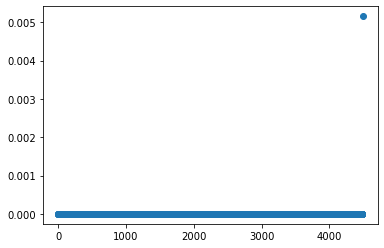

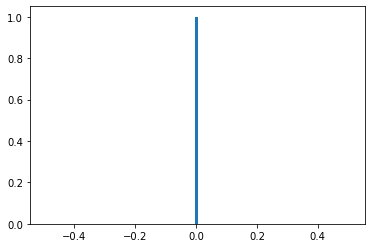

Plot  4 / 16


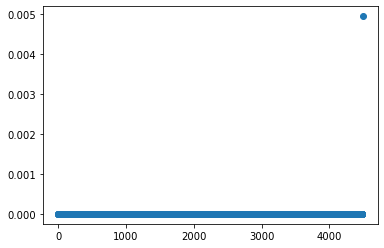

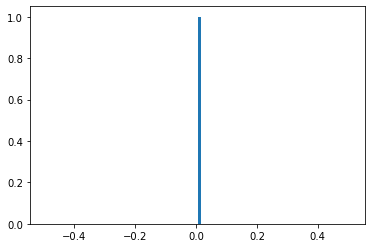

Plot  5 / 16


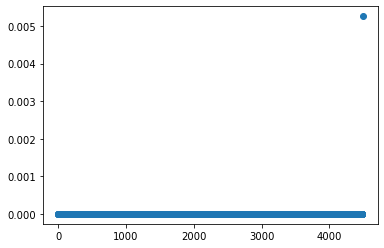

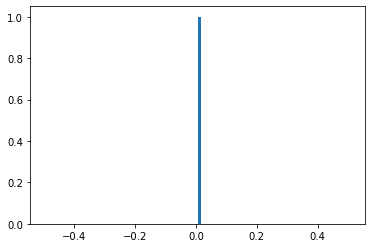

Plot  6 / 16


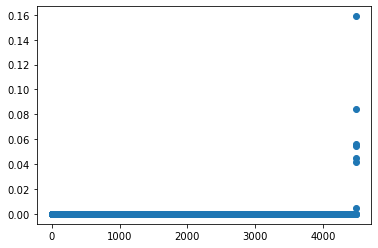

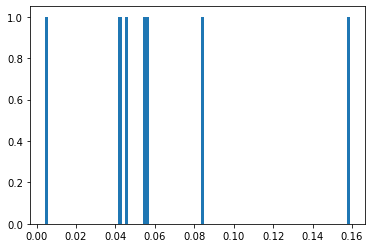

Plot  7 / 16


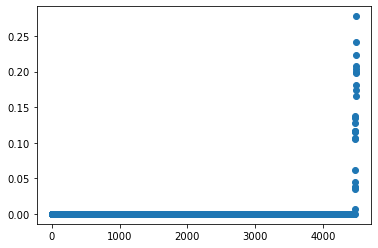

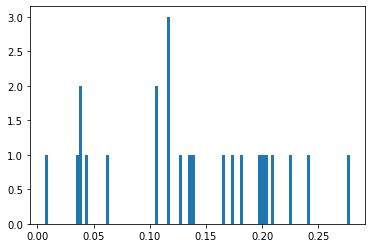

Plot  8 / 16


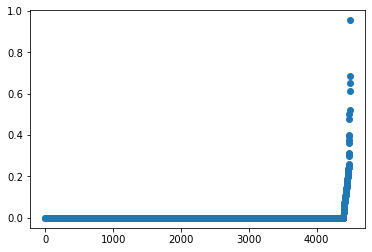

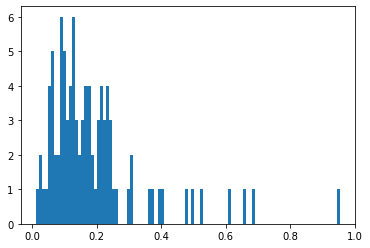

Plot  9 / 16


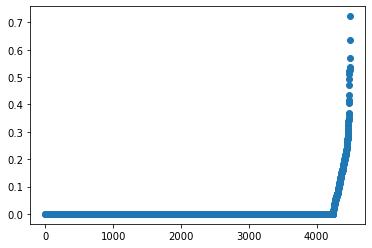

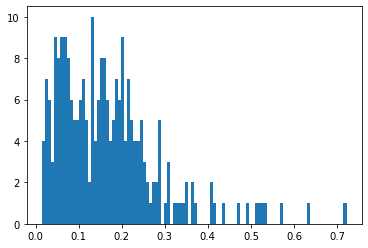

Plot  10 / 16


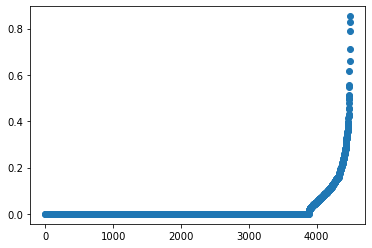

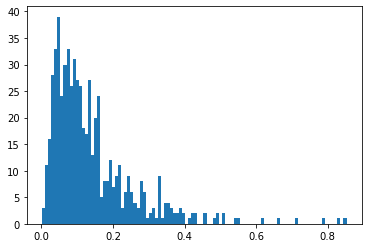

Plot  11 / 16


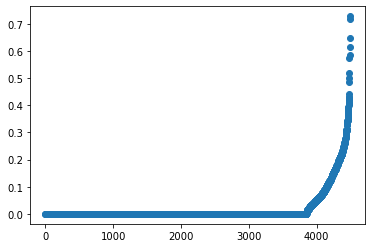

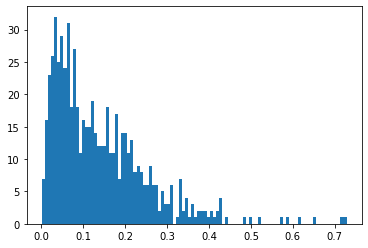

Plot  12 / 16


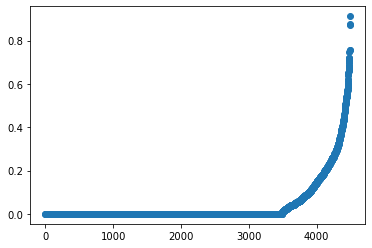

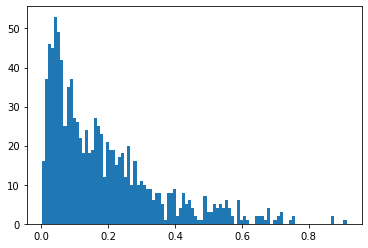

Plot  13 / 16


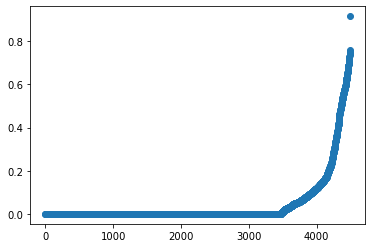

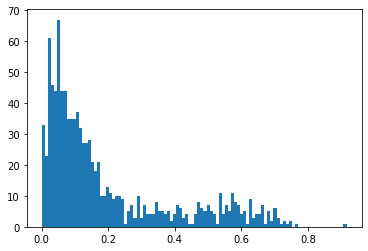

Plot  14 / 16


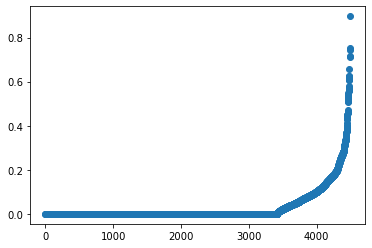

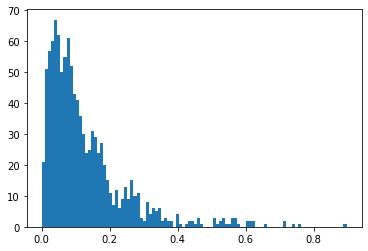

Plot  15 / 16


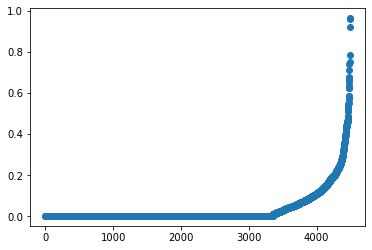

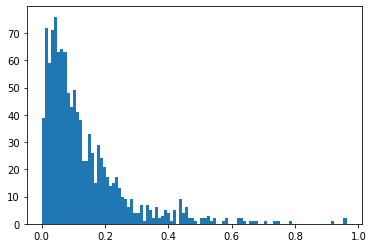

Plot  16 / 16


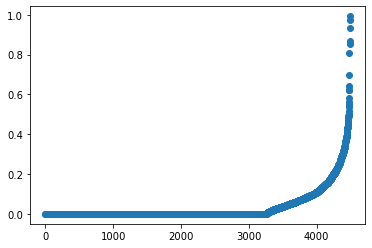

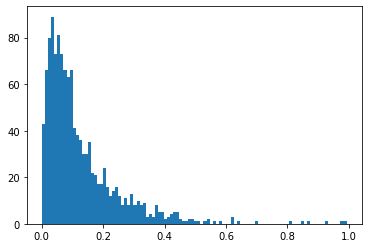

Global distribution


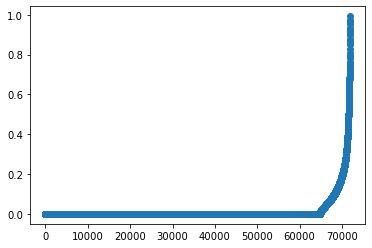

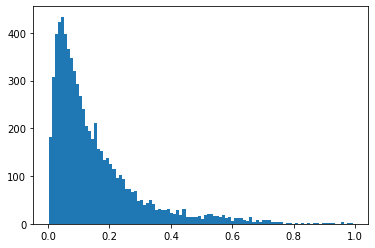

In [7]:
# Distributions plot by plot

for img in range(len(arrows_list)):
    norms = np.linalg.norm(arrows_list[img][1], axis = 1)
    print('Plot ', img+1, '/', len(arrows_list))
    plt.scatter(np.arange(arrows_list[img][1].shape[0]), np.sort(norms))
    plt.show()
    plt.hist(norms[np.where(norms!=0)[0]], bins = 100)
    plt.show()
    
# Global distribution

diff_tot = np.array([])
for img in range(len(arrows_list)):
    diff_tot = np.hstack((diff_tot,np.linalg.norm(arrows_list[img][1], axis = 1)))

print('Global distribution')
plt.scatter(np.arange(len(diff_tot)), np.sort(diff_tot))
plt.show()
plt.hist(diff_tot[np.where(diff_tot!=0)[0]], bins = 100)
plt.show()

Vectors' angles distributions:

Plot  1 / 16


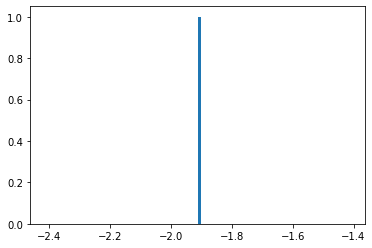

Plot  2 / 16


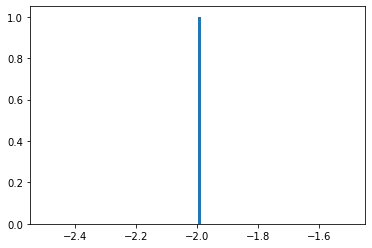

Plot  3 / 16


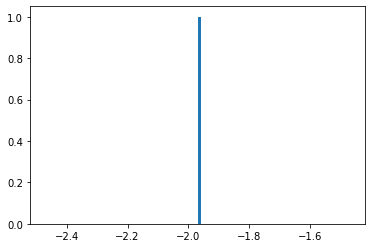

Plot  4 / 16


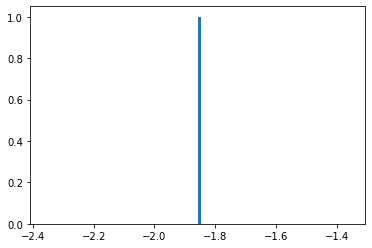

Plot  5 / 16


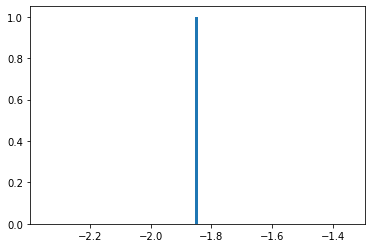

Plot  6 / 16


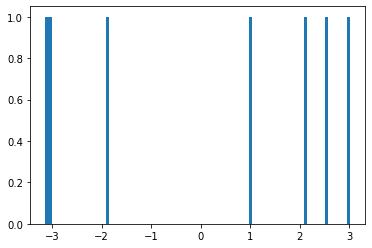

Plot  7 / 16


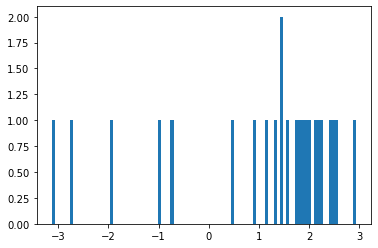

Plot  8 / 16


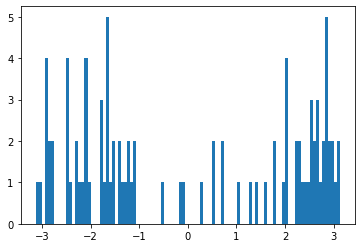

Plot  9 / 16


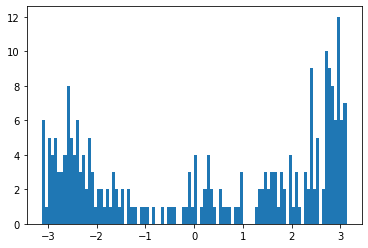

Plot  10 / 16


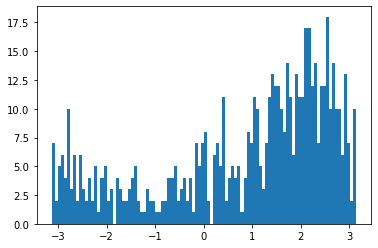

Plot  11 / 16


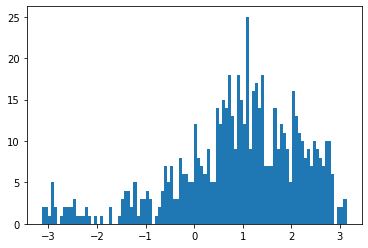

Plot  12 / 16


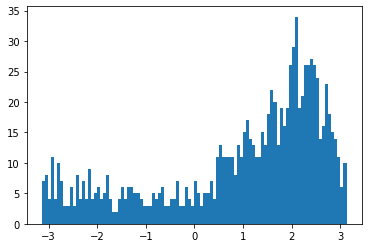

Plot  13 / 16


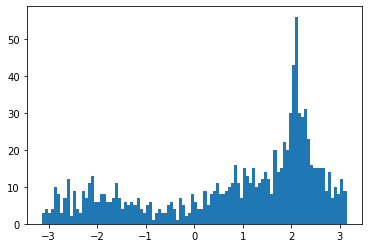

Plot  14 / 16


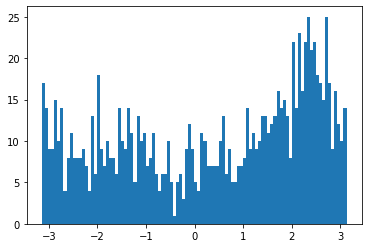

Plot  15 / 16


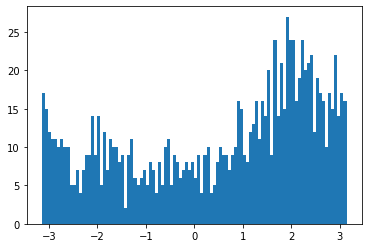

Plot  16 / 16


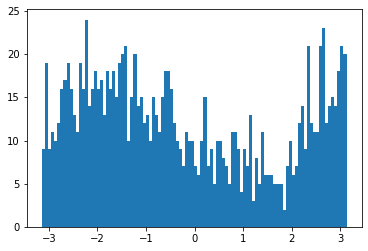

Global distribution


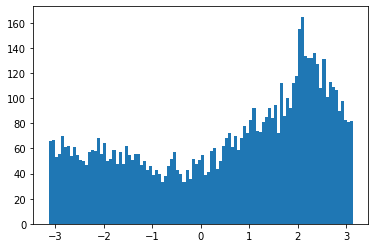

In [8]:
# Distributions plot by plot

for img in range(len(arrows_list)):
    angles = np.angle(arrows_list[img][1].T[0]+1j*arrows_list[img][1].T[1])
    print('Plot ', img+1, '/', len(arrows_list))
    plt.hist(angles[np.where(angles!=0)[0]], bins = 100)
    plt.show()
    
# Global distribution

diff_tot = np.array([])
for img in range(len(arrows_list)):
    diff_tot = np.hstack((diff_tot,np.angle(arrows_list[img][1].T[0]+1j*arrows_list[img][1].T[1])))

print('Global distribution')
plt.hist(diff_tot[np.where(diff_tot!=0)[0]], bins = 100)
plt.show()